# Más allá del precision, recall y el AUC: otras métricas de clasificación

<img src="gatos.jpg">

In [1]:
from sklearn import preprocessing
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Más allá de las tradicionales métricas utilizadas en problemas de clasificación, tales como ROC-AUC, precision, recall y F1, existen otras métricas útiles muy utilizadas.

Tomemos por ejemplo el dataset "abalone", que propone medir la edad de un molusco (binarizada como la variable target "Adulto") a partir de sus características físicas:

In [2]:
df = pd.read_csv('Data/abalone.csv', sep=';')
print('Filas:', df.shape[0], 'Columnas:', df.shape[1])
df.sample(3)

Filas: 3676 Columnas: 10


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Adulto
3170,F,0.570,0.465,0.155,0.8720,0.3245,0.2390,0.285,14,1
1893,I,0.565,0.460,0.155,0.8715,0.3755,0.2150,0.250,10,1
1378,F,0.620,0.500,0.150,1.2930,0.5960,0.3135,0.354,10,1


In [3]:
X = df.drop(['Adulto','Sex'], axis=1)
y = df['Adulto']

In [4]:
pd.Series(y).value_counts(normalize=True)

Adulto
0    0.563928
1    0.436072
Name: proportion, dtype: float64

In [5]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=9)
from sklearn.linear_model import LogisticRegression
log=LogisticRegression()

In [6]:
# Generamos los datasets de train y test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=56)

# Ajustamos a los datos de entrenamiento.
log.fit(X_train, y_train);

# Predecimos etiquetas para los datos de test.
y_pred = log.predict(X_test)
y_pred_proba = log.predict_proba(X_test)

In [7]:
y_pred_proba[:,1]

array([2.64244911e-01, 9.99959033e-01, 9.38770317e-02, ...,
       8.39346167e-01, 5.94048108e-01, 1.30342894e-04])

<a id='metricas'></a>

Tenemos un conjunto de métricas que pueden calcularse aplicando el mismo ordenamiento inicial:

1. Ordenamos los datos de mayor a menor probabilidad predicha.
2. Separamos en deciles.
- Calculamos **"gain"** como la proporción de positivos acumulados para cierto decil (columna *pos_acum_porc*).  
[Gráfico Gain](#gain)<br><br>
- **"Lift"** es una medida complementaria. Lo calculamos como el cociente entre la proporción de positivos acumulados y la proporción de totales acumulados (equivalente a comparar **los positivos detectados por el modelo** vs lo que cabría esperar **si nos guiáramos por el azar**).
[Gráfico Lift](#lift)<br><br>
- **"Decile-wise lift"** es equivalente al lift pero para cada decil. Es decir, es el cociente entre la proporción de positivos y la proporción de totales o casos esperados por el azar. Podemos pensarla como una medida de la efectividad del modelo para cada decil en particular (el modelo va a ser útil en la medida en que este valor sea > 1).
[Gráfico Decile-wise Lift](#dwlift)<br><br>
- **"Kolmogorov-Smirnov o KS"** es la diferencia entre la proporción de positivos acumulados y la proporción de negativos acumulados. En particular nos interesa el **decil** que máximiza la diferencia, y el valor de KS en dicho decil.
[Gráfico KS](#ks)<br><br>

<i>Todas estas métricas nos ayudan a decir que tan bien nuestro modelo "ordena" los casos a partir de la probabilidad asignada, y nos ayuda a separar las clases positiva y negativa.</i>

*Son métricas transversales al punto de corte*, pero que nos pueden indicar un punto de corte adecuado para maximizar cierta métrica. Por ejemplo en una campaña de marketing con recursos limitados, podríamos pensar en atacar el X% de la población mejor scoreada, y ya sabríamos de antemano los resultados esperados.


Ver más: https://www.geeksforgeeks.org/understanding-gain-chart-and-lift-chart/

In [8]:
import kds
chart=kds.metrics.decile_table(y_test, y_pred_proba[:,1],labels=False)
chart['lift_decil']=chart['cnt_resp']/chart['cnt_resp_rndm']

chart2=chart.loc[:,['decile','cnt_cust','cum_cust','cum_cust_pct','cnt_resp','cum_resp','cum_resp_pct','cnt_non_resp','cum_non_resp','cum_non_resp_pct','lift','lift_decil','KS']]
chart2.columns=['decil','tot','tot_acum','tot_acum_porc','pos','pos_acum','pos_acum_porc','neg','neg_acum','neg_acum_porc','lift','lift_decil','KS']
chart2.loc[:,chart2.columns.difference(['lift','lift_decil'])]=chart2.loc[:,chart2.columns.difference(['lift','lift_decil'])].astype('int')

pcs_gain=np.percentile(y_pred_proba[:,1], np.arange(0, 100, 10))
pcs_gain[::-1].sort()
pcs_gain=np.round(pcs_gain,3)
chart2=pd.concat([pd.Series(pcs_gain),chart2],axis=1)
chart2.rename(columns={0:'punto_corte'},inplace=True)

chart2

,punto_corte,decil,tot,tot_acum,tot_acum_porc,pos,pos_acum,pos_acum_porc,neg,neg_acum,neg_acum_porc,lift,lift_decil,KS
0,0.997,1,111.0,111.0,10.0,111.0,111.0,24.0,0.0,0.0,0.0,2.408,2.423581,24.0
1,0.935,2,110.0,221.0,20.0,97.0,208.0,45.0,13.0,13.0,2.0,2.267,2.117904,43.0
2,0.809,3,110.0,331.0,30.0,67.0,275.0,60.0,43.0,56.0,8.0,2.001,1.462882,51.0
3,0.586,4,111.0,442.0,40.0,101.0,376.0,82.0,10.0,66.0,10.0,2.049,2.205240,71.0
4,0.278,5,110.0,552.0,50.0,48.0,424.0,92.0,62.0,128.0,19.0,1.850,1.048035,72.0
5,0.259,6,110.0,662.0,60.0,15.0,439.0,95.0,95.0,223.0,34.0,1.597,0.327511,61.0
6,0.088,7,111.0,773.0,70.0,9.0,448.0,97.0,102.0,325.0,50.0,1.396,0.196507,47.0
7,0.028,8,110.0,883.0,80.0,7.0,455.0,99.0,103.0,428.0,66.0,1.241,0.152838,32.0
8,0.007,9,110.0,993.0,90.0,3.0,458.0,100.0,107.0,535.0,82.0,1.111,0.065502,17.0
9,0.000,10,110.0,1103.0,100.0,0.0,458.0,100.0,110.0,645.0,100.0,1.000,0.000000,0.0


<a id='gain'></a>

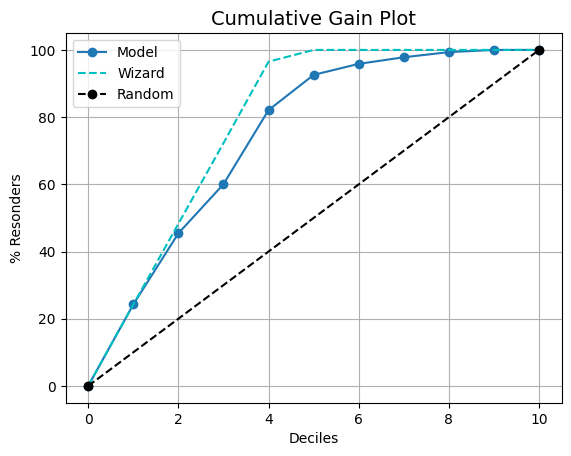

In [9]:
kds.metrics.plot_cumulative_gain(y_test, y_pred_proba[:,1])

**Interpretación Gain**: podemos aplicar el modelo al **20% de los casos** mejor scoreados y estaríamos abarcando el **45% de los casos positivos**.

La línea punteada nos indica la proporción de casos positivos si obtuvieramos casos al azar (sin ningún ordenamiento). Por ej.: si tomáramos el 20% de los casos al azar obtendríamos el 20% de los casos positivos.

<i> "Wizard" nos indica el modelo ideal, si en cada decil encontraramos solamente casos positivos (en este caso, en el 5to decil llegaríamos a detectar el 100% de los casos positivos, dado que la clase positiva es del 43%) </i>

- ¿A que métrica que ya conocemos nos hace acordar?

[Volver](#metricas)


<a id='lift'></a>

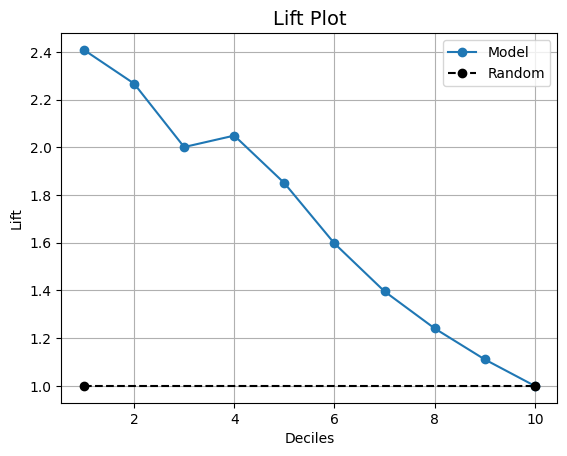

In [10]:
kds.metrics.plot_lift(y_test, y_pred_proba[:,1])


**Interpretación Lift**: si aplicamos el modelo al **20% de los casos** estamos ganándole al azar por **2,2 veces** (lift = 2,2).
<br><br>
Notar que típicamente la curva del lift descenderá desde el punto más alto en los primeros deciles hasta la línea base de 1. En este punto estamos atacando el 100% de los casos y capturando el 100% de los casos positivos (lo esperable al guiarnos por el azar).
<br><br>
¿Podría pensarse en un modelo con un lift negativo? Sí, ¡pero estaría logrando un desempeño aún peor que el azar!

[Volver](#metricas)

<a id='dwlift'></a>

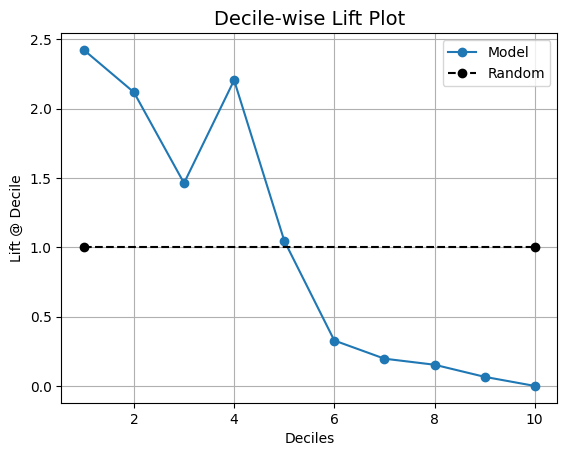

In [11]:
kds.metrics.plot_lift_decile_wise(y_test, y_pred_proba[:,1])

**Interpretación decile-wise lift**: al aplicar el modelo sobre los primeros 5 deciles, estamos obteniendo ganancias respecto al azar. En el 5to decil la ganancia es mínima, por lo que podríamos utilizar esta métrica para argumentar que sería conveniente tomar acciones sobre los 4 primeros deciles.

[Volver](#metricas)

<a id='ks'></a>

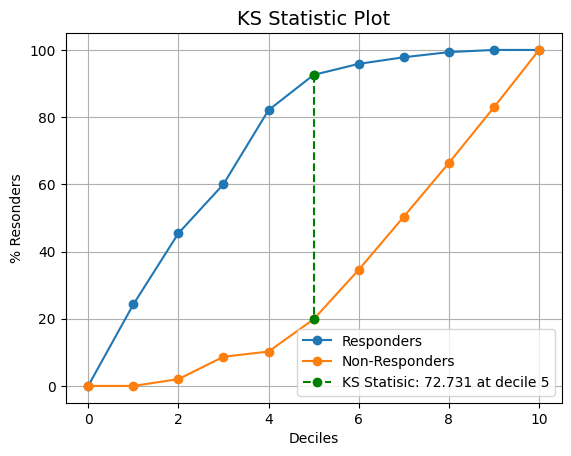

In [12]:
kds.metrics.plot_ks_statistic(y_test, y_pred_proba[:,1])

**Interpretación KS**: en el 5to decil se maximiza la diferencia en la proporción de casos positivos y negativos detectados (72%). Guarda coherencia con la métrica decile-wise lift, en el que veíamos ganancias hasta el 5to decil inclusive. A partir de este decil, las diferencias en las proporciones se van achicando, hasta obtener el 100% de las clases positiva y negativa al abarcar el 100% de la población. En concordancia con esto, observamos que luego de este decil, tenemos valores de decile-wise lift menores a 1.

[Volver](#metricas)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.997,1.000,0.999,111.0,111.0,0.0,45.8,111,100.000,111.0,111.0,111,0.0,10.063,24.236,24.236,0.000,24.236,2.408
1,2,0.936,0.997,0.974,110.0,97.0,13.0,45.8,110,88.182,221.0,208.0,221,13.0,20.036,45.415,48.253,2.016,43.399,2.267
2,3,0.817,0.934,0.852,110.0,67.0,43.0,45.8,110,60.909,331.0,275.0,331,56.0,30.009,60.044,72.271,8.682,51.362,2.001
3,4,0.586,0.803,0.610,111.0,101.0,10.0,45.8,111,90.991,442.0,376.0,442,66.0,40.073,82.096,96.507,10.233,71.863,2.049
4,5,0.278,0.586,0.408,110.0,48.0,62.0,45.8,16,43.636,552.0,424.0,458,128.0,50.045,92.576,100.000,19.845,72.731,1.850
5,6,0.259,0.278,0.269,110.0,15.0,95.0,45.8,0,13.636,662.0,439.0,458,223.0,60.018,95.852,100.000,34.574,61.278,1.597
6,7,0.088,0.259,0.142,111.0,9.0,102.0,45.8,0,8.108,773.0,448.0,458,325.0,70.082,97.817,100.000,50.388,47.429,1.396
7,8,0.028,0.088,0.074,110.0,7.0,103.0,45.8,0,6.364,883.0,455.0,458,428.0,80.054,99.345,100.000,66.357,32.988,1.241
8,9,0.007,0.028,0.023,110.0,3.0,107.0,45.8,0,2.727,993.0,458.0,458,535.0,90.027,100.000,100.000,82.946,17.054,1.111
9,10,0.000,0.007,0.004,110.0,0.0,110.0,45.8,0,0.000,1103.0,458.0,458,645.0,100.000,100.000,100.000,100.000,0.000,1.000


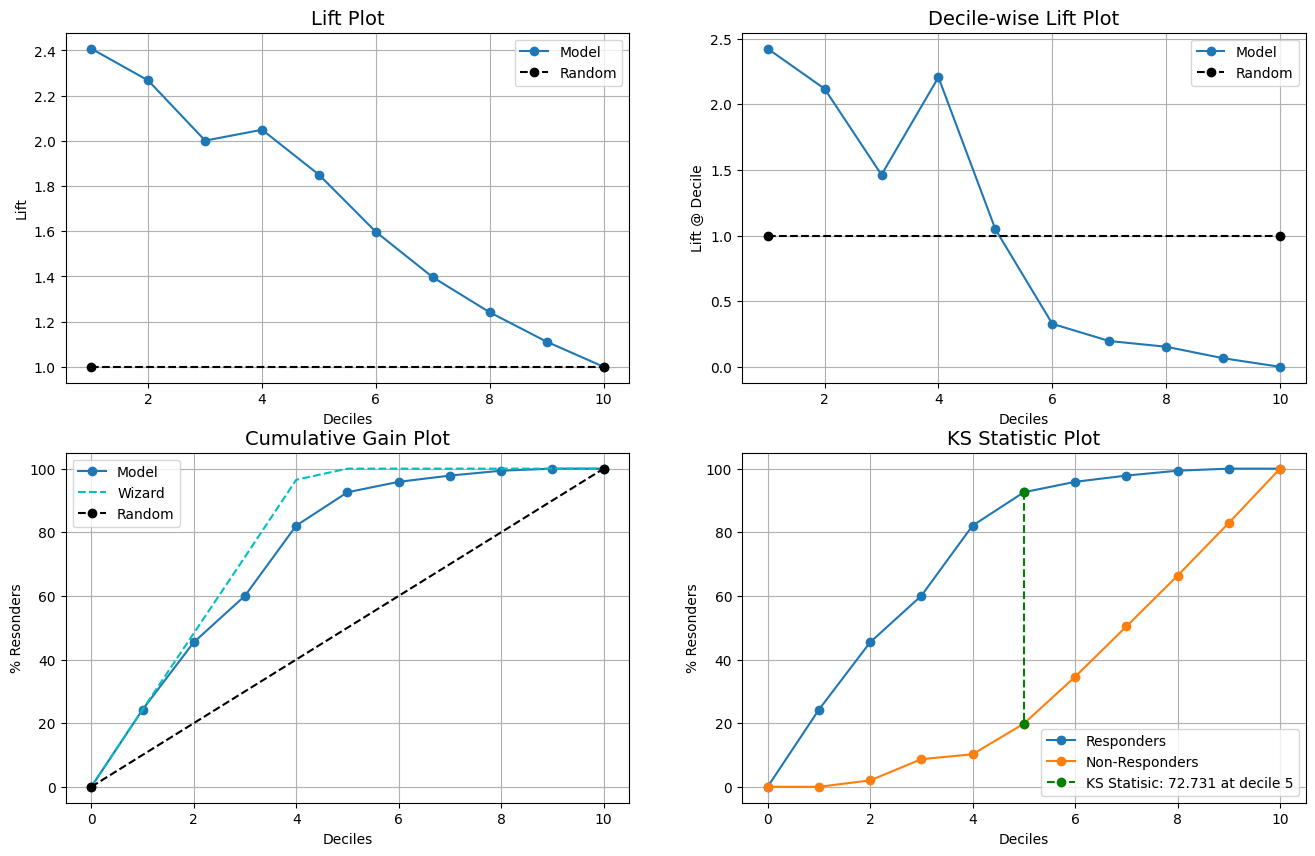

In [13]:
#Vemos todo junto
kds.metrics.report(y_test, y_pred_proba[:,1])

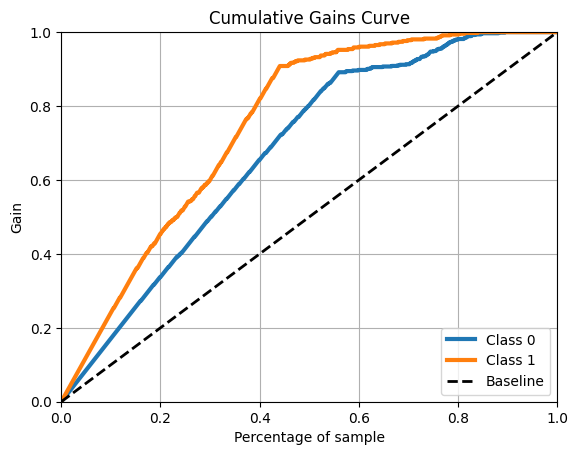

In [14]:
#Con otra librería...

import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba,);


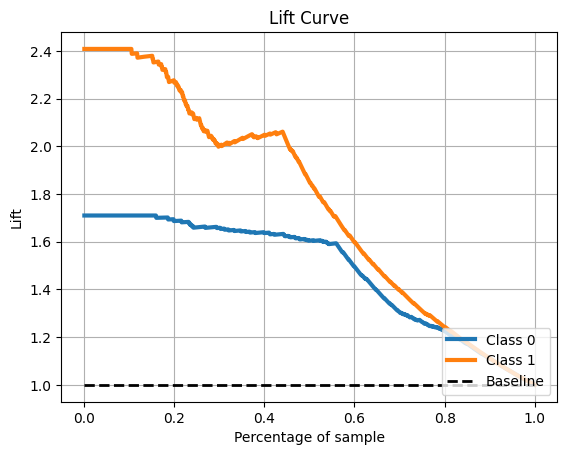

In [15]:
skplt.metrics.plot_lift_curve(y_test, y_pred_proba);

## Curva precision - recall

### ¿Por qué el área bajo la curva ROC (AUC-ROC) no siempre es útil?

- El área bajo la curva ROC es útil para evaluar la bondad de un modelo, incluso ante situaciones de desbalanceo de clases, lo que la vuelve un indicador más robusto que el accuracy.
- Sin embargo, en situaciones de fuerte desbalanceo de clases (por ej, modelos de fraude) esta métrica es insuficiente, por cuanto puede sobreestimar el desempeño de un modelo.

Recordemos como su construye una curva ROC:
- En el eje y tenemos la tasa de verdaderos positivos (recall o sensibilidad):
<br><br>
$$
TPR=\frac{TP}{Total\;positivos\;(TP + FN)}
$$
- Mientras que en el eje x tenemos la tasa de falsos positivos:
<br><br>
$$
FPR=\frac{FP}{Total\;negativos\;(TN + FP)}
$$
O, lo que es lo mismo, la inversa de la especificidad:
<br><br>
$$
Especificidad=\frac{TN}{Total\;negativos\;(TN + FP)}
$$
<br><br>
$$
TPR=1-especificidad
$$

<img src="ejemplo roc-auc.png" width="50%">

Valores bajos en el eje x indican una tasa de falsos positivos baja, mientras que valores altos en el eje y indican una tasa de verdaderos positivos (recall) alta. 

**Un modelo útil** que ofrezca una tasa de verdaderos positivos proporcionalmente más alta que la tasa de altos positivos (es decir, que supere al azar).

**Un modelo ideal** tendría un tasa de verdaderos positivos máxima al mismo tiempo que minimizaría la tasa de falsos positivos, lo que nos ubicaría en la esquina superior izquierda de la curva. 

Sin embargo, un conjunto de datos con clases muy desbalanceadas implicaría que tengamos un nivel de falsos positivos relativamente muy bajo en relación a una masa de verdaderos negativos muy alta. Es decir, el FPR tendría un numerador muy bajo y un denominador muy alto, lo que resultaría en una tasa muy baja, con niveles de TPR (recall) más altos.

Así, podemos tener un modelo con un ROC-AUC elevado (>80%) que al mismo tiempo presente niveles de recall y precision muy bajos.

### Una solución al problema: la curva precision-recall

- Esta curva nos muestra las métricas precision y recall para todos los puntos de corte.
- Oscila entre 0 y 1.
- Podemos compararla contra el baseline de predecir siempre la clase 1, para todo punto de corte (equivalente a la proporción de la clase 1).
- Son útiles cuando hay un fuerte desbalanceo de clases, ya que las curvas ROC pueden ser demasiado optimistas por la presencia proporcionalmente mayor de verdaderos negativos (por ej., en fraude).

Ver más: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

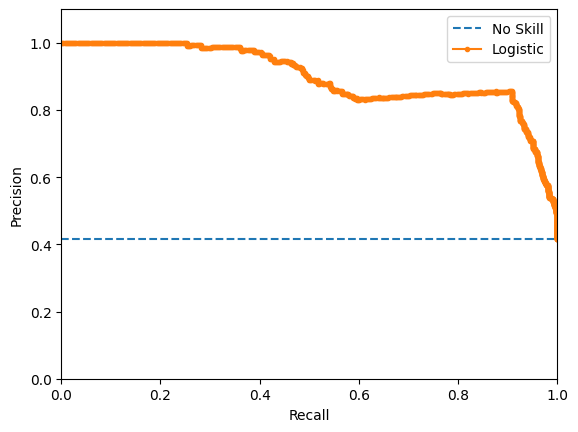

In [16]:
from sklearn.metrics import precision_recall_curve,auc
from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_proba[:,1])

no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.xlim((0,1))
pyplot.ylim((0,1.1))

# show the legend
pyplot.legend()
# show the plot
pyplot.show()

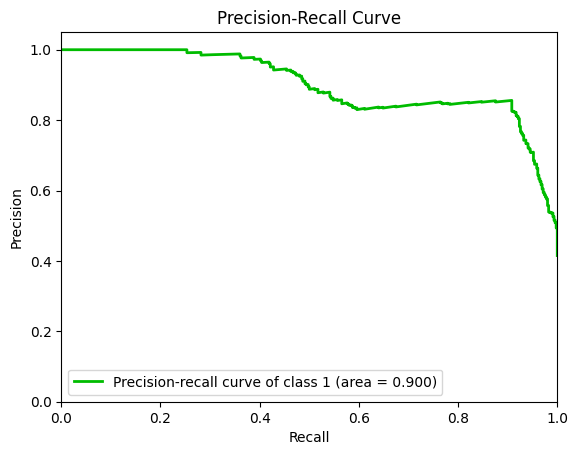

In [17]:
#Utilizando scikitplot
skplt.metrics.plot_precision_recall(y_test, y_pred_proba,classes_to_plot=1,plot_micro=False,);

In [18]:
from sklearn.metrics import precision_recall_curve,auc
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:,1])
# calculate precision-recall AUC
pr_auc = auc(recall, precision)
print(f'PR-AUC obtenido: {round(pr_auc,2)} vs PR-AUC baseline: {round(y_test.value_counts(normalize=True)[1],2)}')

PR-AUC obtenido: 0.9 vs PR-AUC baseline: 0.42


# Función de ganancia

<img src="tiorico.jpg" width="50%">

A menudo los científicos de datos trabajamos con áreas de negocio que no siempre tienen la formación técnica o predisposición para entender las variables utilizadas en la medición de los modelos.

**Por eso es útil armar una función de ganancia que exprese la efectividad de un modelo en términos monetarios.**

- Podemos asignarle un costo/ingreso específico a cada cuadrante de la matriz de confusión: 
    - ingresos en el caso de verdaderos positivos y negativos y 
    - pérdidas en el caso de falsos positivos y negativos...
    y a partir de ello definir la función de <i>ganancia</i>: <br><br>
Ganancia = (TP x ingreso_tp + TN x ingreso_tn) - (FP x costo_fp + FN x costo_fn)
<br><br>
- De esta manera llegaremos a un punto de corte que maximice la ganancia esperada.
- Si los **falsos positivos** son más costosos que los falsos negativos, probablemente nuestro modelo priorice **precision** vs recall.
- Si los **falsos negativos** son más costosos que los falsos positivos, probablemente nuestro modelo priorice **recall** vs precision.
<br><br>

Por ejemplo, en un modelo de *churn* de una empresa de servicios, podemos pensar que lanzamos una campaña con descuentos para retener clientes:
<br>
- Tendríamos **ingresos** por los clientes que logramos retener, menos los gastos del descuento ofrecido (*verdaderos positivos*).
- Tendríamos **pérdidas** por los *falsos positivos*, es decir, descuentos ofrecidos a clientes que no se hubieran dado de baja, pero que el modelo catalogó (erróneamente) como positivos.
- Podríamos no tener en cuenta los verdaderos o falsos negativos, ya que no cambia la situación con respecto al esquema original sin aplicar un modelo.


### Vamos al código...

In [19]:
from sklearn.preprocessing import binarize
from sklearn.metrics import classification_report, confusion_matrix

def prediction_metrics(y_test,y_pred_proba,costo_tp=0,costo_tn=0,costo_fp=0,costo_fn=0):
    
    """
    A partir de dos arrays, uno con la clase real y otro con las probabilidades arrojadas por el modelo de clasificación 
    binario, calcula las métricas precision, recall y F1 para 100 puntos de corte entre 0 y 0.99.
    Además calcula la ganancia esperada para cada punto de corte, a partir de los costos unitarios de los verdaderos positivos,
    verdaderos negativos, falsos positivos y falsos negativos.
    
    Parámetros
    ----------
    y_test (obligatorio): array o serie con las etiquetas (0/1) reales del conjunto de datos
    y_pred_proba (obligatorio): array o dataframe de dimensión N x 2 con las probabilidades arrojadas por un modelo de
    clasificación para las clases negativa y positiva
    costo_tp (opcional): costo/ganancia unitario para los verdaderos positivos. Si se trata de una ganancia, tiene que ser un número 
    positivo, mientras que si se trata de un costo, tiene que ser un número negativo.
    costo_tn (opcional): costo/ganancia unitario para los verdaderos negativos.
    costo_fp (opcional): costo/ganancia unitario para los falsos positivos.
    costo_fn (opcional): costo/ganancia unitario para los falsos negativos.

    """
        
    metricas=list()
    pcs=np.arange(0,1,0.01)
    for i in pcs:
        y_pred = binarize(y_pred_proba, threshold=i)[:,1]
        metricas_aux=classification_report(y_test, y_pred,output_dict=True,zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        ganancia=tp*costo_tp+tn*costo_tn+fp*costo_fp+fn*costo_fn
        metricas_aux['1']['ganancia']=ganancia
        metricas.append(metricas_aux['1'])
        
    metricas_df=pd.DataFrame(metricas)
    metricas_df.drop(columns=['support'],inplace=True)
    metricas_df=pd.concat([pd.Series(pcs),metricas_df],axis=1)
    metricas_df.rename(columns={0:'pc'},inplace=True)
    return(metricas_df)

In [20]:
costo_tn=0
costo_tp=100
costo_fn=-50
costo_fp=-5
metricas_df=prediction_metrics(y_test,y_pred_proba,costo_tp,costo_tn,costo_fp,costo_fn)
# metricas_df.sort_values(by='precision',ascending=False)
metricas_df.sort_values(by='ganancia',ascending=False)

,pc,precision,recall,f1-score,ganancia
3,0.03,0.525404,0.993450,0.687311,43295
1,0.01,0.466871,1.000000,0.636553,43185
2,0.02,0.466871,1.000000,0.636553,43185
4,0.04,0.525463,0.991266,0.686838,43150
5,0.05,0.525463,0.991266,0.686838,43150
...,...,...,...,...,...
95,0.95,0.944954,0.449782,0.609467,7940
96,0.96,0.963542,0.403930,0.569231,4815
97,0.97,0.987730,0.351528,0.518519,1240
98,0.98,0.987730,0.351528,0.518519,1240


**Caso N°1**: errores FN más costosos
- Los errores tipo Falso Negativo son relativamente más costosos que los errores Falso Positivo, por lo que priorizamos RECALL.
- Queremos detectar la mayor parte de casos positivos, aunque cometamos más errores, es decir obtenemos una mayor ganancia con **tasas de recall más altas**, aunque tengamos tasas de precision menores. Esto estará asociado a **puntos de corte más bajos** (somos menos exigentes con el modelo).

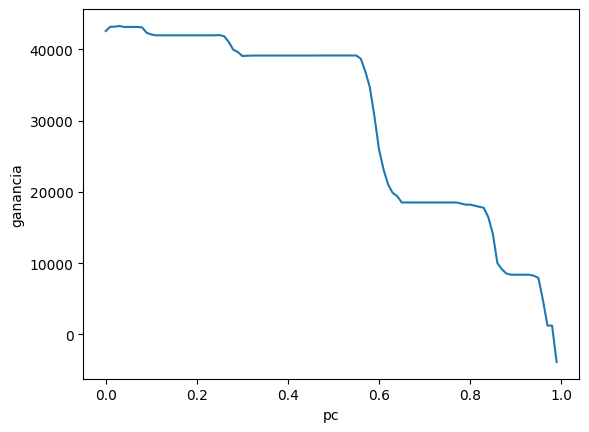

In [21]:
sns.lineplot(data=metricas_df,x='pc',y='ganancia');

In [22]:
costo_tn=0
costo_tp=100
costo_fn=-5
costo_fp=-500
metricas_df=prediction_metrics(y_test,y_pred_proba,costo_tp,costo_tn,costo_fp,costo_fn)
metricas_df.sort_values(by='ganancia',ascending=False)

,pc,precision,recall,f1-score,ganancia
96,0.96,0.963542,0.403930,0.569231,13635
98,0.98,0.987730,0.351528,0.518519,13615
97,0.97,0.987730,0.351528,0.518519,13615
94,0.94,0.945455,0.454148,0.613569,13550
95,0.95,0.944954,0.449782,0.609467,13340
...,...,...,...,...,...
4,0.04,0.525463,0.991266,0.686838,-159620
3,0.03,0.525404,0.993450,0.687311,-160015
1,0.01,0.466871,1.000000,0.636553,-215700
2,0.02,0.466871,1.000000,0.636553,-215700


**Caso N°2**: errores FP más costosos

- Los errores tipo Falso Positivo son relativamente más costosos que los errores Falso Negativo, por lo que priorizamos PRECISION.
- Queremos ser más precisos, aunque no detectemos tantos casos positivos, es decir obtenemos una mayor ganancia con **tasas de precision más altas**, aunque tengamos tasas de recall menores. Esto estará asociado a **puntos de corte más altos** (somos más exigentes con el modelo).

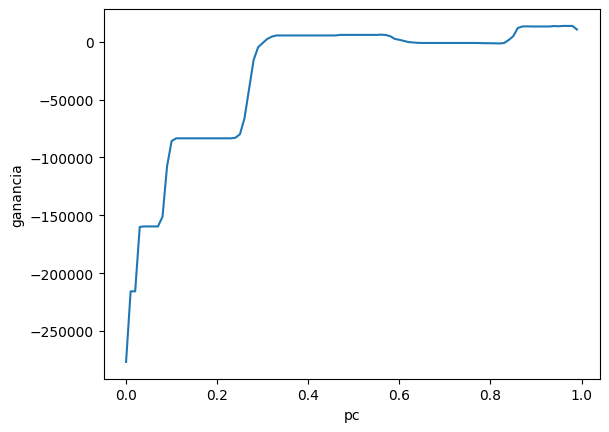

In [23]:
sns.lineplot(data=metricas_df,x='pc',y='ganancia');

Como se aprecia en el 2do caso, puede ocurrir que no queramos maximizar la ganancia arrojada por un modelo, sino reducir una pérdida ya existente. **Siempre hay que comparar la ganancia/reducción de pérdida obtenida por el modelo con la situación preexistente de no usar ningún modelo.**

Ver más acá:
- http://albahnsen.github.io/CostSensitiveClassification/index.html
- https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/

# Métricas multiclase

Vemos un dataset de diamantes, en el que queremos predecir el tipo de corte de un diamante a partir de sus características físicas. Se trata de un problema multiclase, con 5 posibles categorías.

In [24]:
from sklearn.datasets import load_wine
wine_X,wine_y = load_wine(return_X_y=True)

diamonds=pd.read_csv('Data/diamonds.csv').drop(columns=['Unnamed: 0'])
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [25]:
X_d=diamonds.drop(columns=['cut','color','clarity'])
y_d=diamonds['cut']

In [26]:
pd.Series(y_d).value_counts(normalize=True)

cut
Ideal        0.399537
Premium      0.255673
Very Good    0.223990
Good         0.090953
Fair         0.029848
Name: proportion, dtype: float64

In [27]:
# Generamos los datasets de train y test.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_sc=scaler.fit_transform(X_d);

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_sc, y_d, test_size = 0.30, random_state=56)

log_d=LogisticRegression()

# Ajustamos a los datos de entrenamiento.
log_d.fit(X_train_d, y_train_d);

# Predecimos etiquetas para los datos de test.
y_pred_d = log_d.predict(X_test_d)
y_pred_proba_d = log_d.predict_proba(X_test_d)

C:\Users\FVeliz\AppData\Local\miniconda3\envs\itba_apa_env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


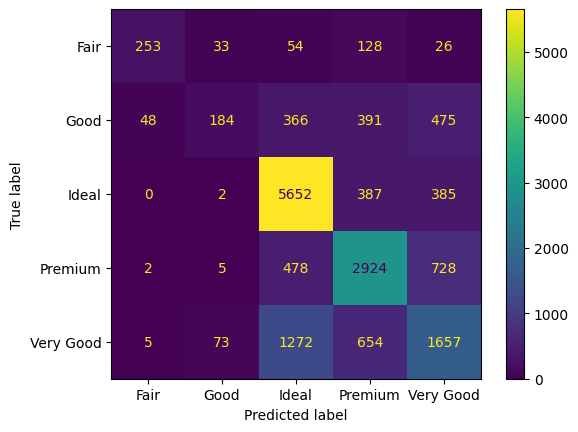

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(log_d, X_test_d, y_test_d) 
plt.show()

- Podemos calcular las métricas para cada clase, pensándola como la clase positiva vs el resto<br><br>
- Es decir, podríamos pensar en cinco matrices de confusión:
    - clase 'Fair' vs el resto.
    - clase 'Good' vs el resto.
    - clase 'Ideal' vs el resto.
    - clase 'Premium' vs el resto.
    - clase 'Very Good' vs el resto.<br><br>
- A partir de estas cinco matrices de confusión, podemos promediar las métricas ya conocidas (precision, recall y F1), de tres formas:
    - Macro: es simplemente la media aritmética de las tres clases.
    - Weighted: es la media ponderada por el peso de cada clase real.
    - Micro: es equivalente al accuracy (para las tres métricas), por lo que no nos servirá para datasets desbalanceados.<br><br>
- Para el caso de AUC, también tenemos las tres formas de promediar
    - En el caso particular del promedio Micro, la métrica resulta de tener en cuenta la totalidad de aciertos y errores, por lo que va a estar **sobrerrepresentada la clase mayoritaria**.

In [29]:
#Podemos ver que la clase más numerosa es Ideal, por lo que en el promedio pesado el recall aumenta notablemente
print(classification_report(y_test_d, y_pred_d))

              precision    recall  f1-score   support

        Fair       0.82      0.51      0.63       494
        Good       0.62      0.13      0.21      1464
       Ideal       0.72      0.88      0.79      6426
     Premium       0.65      0.71      0.68      4137
   Very Good       0.51      0.45      0.48      3661

    accuracy                           0.66     16182
   macro avg       0.66      0.54      0.56     16182
weighted avg       0.65      0.66      0.63     16182



In [30]:
from sklearn.metrics import roc_auc_score

auc_macro=roc_auc_score(y_test_d, y_pred_proba_d, average="macro", multi_class="ovr")
auc_weighted=roc_auc_score(y_test_d, y_pred_proba_d, average="weighted", multi_class="ovr")

print(f'Auc_macro: {auc_macro}')
print(f'Auc_weighted: {auc_weighted}')

Auc_macro: 0.8225233398290122
Auc_weighted: 0.8384181863731724


In [31]:
#Para graficar las curvas ROC, tenemos que utilizar la función OneVsRestClassifier, que entrena tantos modelos binarios
#como clases haya

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

y_bin = label_binarize(y_d, classes=['Fair','Good','Ideal','Premium','Very Good'])
n_classes = y_bin.shape[1]

# shuffle and split training and test sets
X_train_d2, X_test_d2, y_train_d2, y_test_d2 = train_test_split(X_sc, y_bin, test_size=0.3, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    LogisticRegression()
)
y_pred_d2 = classifier.fit(X_train_d2, y_train_d2).decision_function(X_test_d2)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_d2[:, i], y_pred_d2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_d2.ravel(), y_pred_d2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

C:\Users\FVeliz\AppData\Local\Temp\ipykernel_31164\3002326588.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


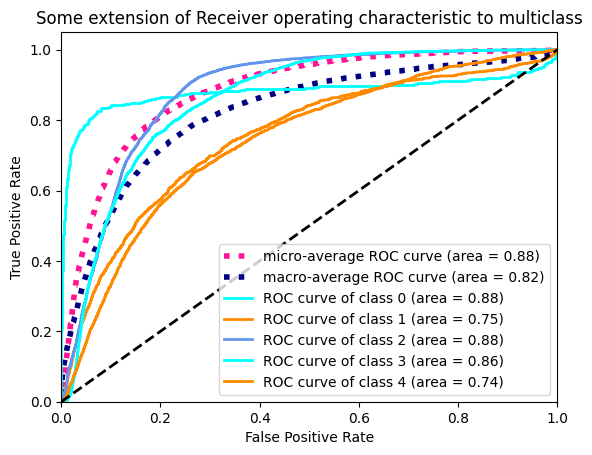

In [32]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Índice **Kappa**

- Es una métrica similar al accuracy, pero que tiene en cuenta el desbalanceo de clases, y es utilizada en los problemas multiclase.
- Surge de comparar las predicciones generadas por dos sistemas de puntuación diferentes. En nuestro caso, comparamos las predicciones generadas por el modelo vs los valores reales.
- Compara los aciertos obtenidos con el modelo (accuracy), contra lo que cabría esperar si nos guiáramos por el azar. En otras palabras, el accuracy efectivamente obtenido contra el accuracy esperado en base al azar.
- Se calcula de la siguiente forma:


<img src="kappa.png">

Siendo:
- p_0: el acuerdo entre casos predichos y casos reales, es decir, la diagonal de la matriz de confusión (accuracy)
- p_e: la probabilidad de que haya *acuerdo* entre predicciones y realidad por azar. Para esto hay que sumar el producto de las probabilidades marginales. ¿Cómo hacemos este cálculo?
1. Obtenemos las probabilidades marginales para cada categoría, para los casos reales y los predichos:
2. Sumamos estas probabilidades para obtener p_e
3. Aplicamos la cuenta

In [33]:
vc_test=y_d.value_counts(normalize=True)
vc_test

cut
Ideal        0.399537
Premium      0.255673
Very Good    0.223990
Good         0.090953
Fair         0.029848
Name: proportion, dtype: float64

In [34]:
vc_pred=pd.Series(y_pred_d).value_counts(normalize=True)
vc_pred

Ideal        0.483377
Premium      0.277098
Very Good    0.202138
Fair         0.019033
Good         0.018354
Name: proportion, dtype: float64

In [35]:
vc_kappa=pd.concat([vc_test,vc_pred],axis=1)
vc_kappa.columns=['test','pred']
vc_kappa['pe']=vc_kappa.test*vc_kappa.pred
vc_kappa

,test,pred,pe
Ideal,0.399537,0.483377,0.193127
Premium,0.255673,0.277098,0.070846
Very Good,0.223990,0.202138,0.045277
Good,0.090953,0.018354,0.001669
Fair,0.029848,0.019033,0.000568


In [36]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_test_d,y_pred_d)
print(f'Accuracy: {accuracy}')

kappa_manual=1-((1-accuracy)/(1-sum(vc_kappa.pe)))

print(f'Kappa manual: {kappa_manual}')

#Método incluido en sklearn
from sklearn.metrics import cohen_kappa_score

print(f'Kappa Sklearn: {cohen_kappa_score(y_test_d, y_pred_d)}')

Accuracy: 0.6593746137683846
Kappa manual: 0.505273588521337
Kappa Sklearn: 0.5057906100276632


- El valor Kappa típicamente oscilará entre 0 y 1 (puede ser menor a 0, en cuyo caso, ¡nuestro modelo estaría funcionando peor que el azar!)
- Los valores de este índice se pueden interpretar de la siguiente forma:
    - 0-0,2: leve acuerdo entre predicciones y valores reales (no no estamos diferenciando del azar)
    - 0,2-0,4: poco acuerdo
    - 0,4-0,6: acuerdo moderado
    - 0,6-0,8: acuerdo sustancial
    - 0,8-1: acuerdo casi perfecto
- Pero como solemos decir en data science... *depende del problema* :)  

- En este caso particular, obtuvimos un índice Kappa de 0,51, con lo que podemos decir que nos diferenciamos moderadamente del azar

# PRÁCTICA

A partir del viejo y querido dataset del Titanic:
1. Ajustar un modelo XGBoost y calcular las métricas vistas en clase.
<br><br>
2. Imaginemos que hay 179 personas a bordo (el set de test) y tenemos botes salvavidas sólo para 72 personas. Si escogemos el 40% de las personas con mayores chances de sobrevivir, ¿cuántas sobrevivirían? (Estamos asumiendo que no todas las personas recogidas por los botes van a sobrevivir)

In [37]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
df = pd.read_csv('Data/Titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
vars_cat=['Sex','Pclass','Embarked']
for col in vars_cat:
    df[col] = df[col].astype('object')
    
df.loc[:,['Cabin','Embarked']]=df.loc[:,['Cabin','Embarked']].fillna('NA')
df=df.drop(columns=['PassengerId','Name','Ticket','Cabin'])

train, test = train_test_split(df, test_size=0.20, random_state=42)
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


In [39]:
encoder = OneHotEncoder(drop='first',sparse=False)
train_onehot = encoder.fit_transform(train[vars_cat])
train_onehot=pd.DataFrame(train_onehot,columns=encoder.get_feature_names_out())

train_ohe=pd.concat([train,train_onehot],axis=1)
train_ohe.drop(columns=vars_cat,inplace=True)
train_ohe

C:\Users\FVeliz\AppData\Local\miniconda3\envs\itba_apa_env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Survived,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3,Embarked_NA,Embarked_Q,Embarked_S
0,0,45.5,0,0,28.5000,1.0,0.0,0.0,0.0,0.0,1.0
1,0,23.0,0,0,13.0000,1.0,1.0,0.0,0.0,0.0,1.0
2,0,32.0,0,0,7.9250,1.0,0.0,1.0,0.0,0.0,1.0
3,0,26.0,1,0,7.8542,1.0,0.0,1.0,0.0,0.0,1.0
4,0,6.0,4,2,31.2750,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
707,1,21.0,0,0,7.6500,0.0,0.0,1.0,0.0,0.0,1.0
708,0,NaN,0,0,31.0000,1.0,0.0,0.0,0.0,0.0,1.0
709,0,41.0,2,0,14.1083,1.0,0.0,1.0,0.0,0.0,1.0
710,1,14.0,1,2,120.0000,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
test_onehot = encoder.transform(test[vars_cat])
test_onehot=pd.DataFrame(test_onehot,columns=encoder.get_feature_names_out())

test_ohe=pd.concat([test,test_onehot],axis=1)
test_ohe.drop(columns=vars_cat,inplace=True)
test_ohe

,Survived,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3,Embarked_NA,Embarked_Q,Embarked_S
0,1,NaN,1,1,15.2458,1.0,0.0,1.0,0.0,0.0,0.0
1,0,31.0,0,0,10.5000,1.0,1.0,0.0,0.0,0.0,1.0
2,0,20.0,0,0,7.9250,1.0,0.0,1.0,0.0,0.0,1.0
3,1,6.0,0,1,33.0000,0.0,1.0,0.0,0.0,0.0,1.0
4,1,14.0,1,0,11.2417,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
174,0,17.0,0,0,7.1250,1.0,0.0,1.0,0.0,0.0,1.0
175,0,NaN,0,0,7.2250,1.0,0.0,1.0,0.0,0.0,0.0
176,1,38.0,1,5,31.3875,0.0,0.0,1.0,0.0,0.0,1.0
177,1,17.0,0,0,10.5000,0.0,1.0,0.0,0.0,0.0,1.0


In [41]:
from xgboost import XGBClassifier

y_train=train['Survived']
y_test=test['Survived']

X_train_ohe=train_ohe.drop(columns=['Survived'])
X_test_ohe=test_ohe.drop(columns=['Survived'])

model_xgb_ohe = XGBClassifier(n_jobs=3)
model_xgb_ohe.fit(X_train_ohe,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=3, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [42]:
y_pred_proba=model_xgb_ohe.predict_proba(X_test_ohe)

# Bibliografía:

- https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362
- https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd
- https://www.statisticshowto.com/cohens-kappa-statistic/
- https://www.mydatamodels.com/blog/multiclass-classification-metrics/